cuda
0.5176


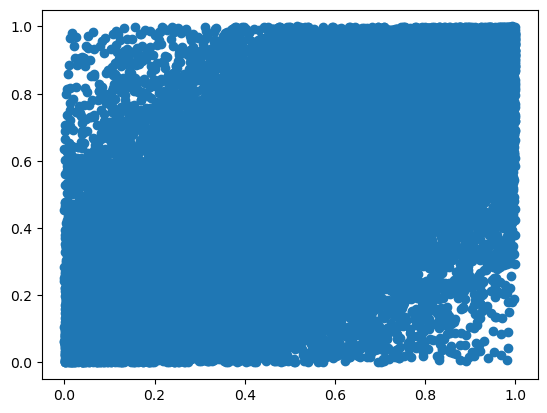

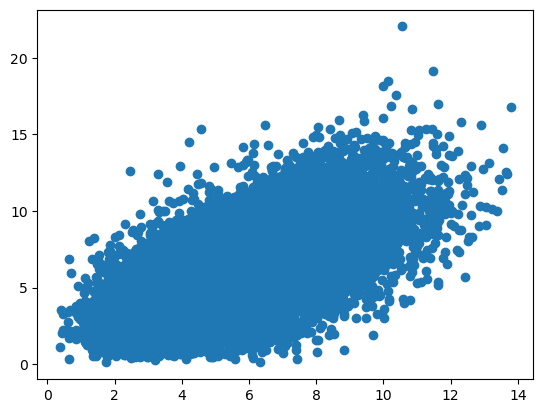

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

seed = 142857
rng = np.random.default_rng(seed)

from statsmodels.distributions.copula.api import (
    CopulaDistribution, GumbelCopula, FrankCopula, ClaytonCopula)

# torch.set_num_threads(8)
torch.backends.cudnn.allow_tf32 = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

torch.set_default_tensor_type(torch.DoubleTensor)

# Generate synthetic data (time-to-event and censoring indicator)
# np.random.seed(285714)
v_e=4; rho_e=14; v_c=3; rho_c=16

size = 30000
dim = 10
batch_size = 20000


# generate X from 10 dimensional uniform distribution from 0 to 1
# X = np.random.uniform(0, 1, (size, dim))
X = rng.uniform(0, 1, (size, dim))
# generate censoring risk coefficient beta from 10 dimensional uniforma distribution from 0 to 1
# beta_c = np.random.uniform(0, 1, (dim, ))
beta_c = rng.uniform(0, 1, (dim, ))
# generate event risk coefficient beta_e from 10 dimensional uniforma distribution from 0 to 1
# beta_e = np.random.uniform(0, 1, (dim,))
beta_e = rng.uniform(0, 1, (dim,))
# multiply beta_e with X to get event risk
event_risk = np.matmul(X, beta_e).squeeze()
# multiple beta_c with X to get censoring risk
censoring_risk = np.matmul(X, beta_c).squeeze()


copula = FrankCopula(theta=5)
sample = copula.rvs(size,random_state=rng)
u = sample[:, 0]
v = sample[:, 1]
plt.scatter(u,v)


# Generate according to Algorithm 2 in "Copula-based Deep Survival Models for Dependent Censoring"
def inverse_transform(value, risk, shape, scale):
    return (-np.log(value)/np.exp(risk))**(1/shape)*scale       
    # return (-np.log(1-value)/np.exp(risk))**(1/shape)*scale


event_time = inverse_transform(u, event_risk, v_e, rho_e)
censoring_time = inverse_transform(v, censoring_risk, v_c, rho_c)

fig = plt.figure()
plt.scatter(event_time, censoring_time)

# check censoring rate 
print(np.sum(event_time<censoring_time)/len(event_time))

# create observed time 
observed_time = np.minimum(event_time, censoring_time)
event_indicator = (event_time<censoring_time).astype(int)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

times_tensor = torch.tensor(observed_time, dtype=torch.float64).to(device)
event_indicator_tensor = torch.tensor(event_indicator, dtype=torch.float64).to(device)
covariate_tensor = torch.tensor(X, dtype=torch.float64).to(device)
train_data = TensorDataset(covariate_tensor[0:20000], times_tensor[0:20000], event_indicator_tensor[0:20000])
val_data = TensorDataset(covariate_tensor[20000:], times_tensor[20000:], event_indicator_tensor[20000:])
train_loader = DataLoader(train_data, batch_size= batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size= batch_size, shuffle=True)

### Define Likelihood with ACNET copula

In [ ]:
from torch.autograd import Function, gradcheck
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pickle
import os,sys
sys.path.append(os.path.abspath('../'))
from main import sample

num_epochs = 500000

In [ ]:
from dirac_phi import DiracPhi
from survival import SurvivalCopula
from survival import sample


# Early stopping
best_val_loglikelihood = float('-inf')
epochs_no_improve = 0
early_stop_epochs = 2000

# Parameters for ACNet
depth = 2
widths = [100, 100]
lc_w_range = (0, 1.0)
shift_w_range = (0., 2.0)

phi = DiracPhi(depth, widths, lc_w_range, shift_w_range, device, tol = 1e-10).to(device)
model = SurvivalCopula(phi, device = device, num_features=10, tol=1e-10).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.01)


train_loss_per_epoch = []
print("Start training!")
for epoch in range(num_epochs):
    loss_per_minibatch = []
    for i, (x , t, c) in enumerate(train_loader, 0):
        # optimizer_copula.zero_grad()
        # optimizer_event.zero_grad()
        # optimizer_censoring.zero_grad()
        optimizer.zero_grad()

        p = model(x, t, c, max_iter = 10000)
        logloss = -p
        logloss.backward() 
        scalar_loss = (logloss/p.numel()).detach().cpu().numpy().item()
        
        optimizer.step()
        # optimizer_censoring.step()
        # optimizer_event.step()
        # optimizer_copula.step()
        
        loss_per_minibatch.append(scalar_loss)
    train_loss_per_epoch.append(np.mean(loss_per_minibatch))
    if epoch % 100 == 0:
        print('Training loss at epoch %s: %.5f' %
                (epoch, train_loss_per_epoch[-1]))
        print(f"Shape Event: {model.shape_t.item(): .3f},\
            Shape Censoring: {model.shape_c.item(): .3f},\
            Scale Event: {model.scale_t.item(): .3f}, Scale Censoring: {model.scale_c.item(): .3f}")
    
        # val_loglikelihoods = []
        for i, (x_val, t_val, c_val) in enumerate(val_loader, 0):
            val_loglikelihood = model(x_val, t_val, c_val, max_iter = 10000)

        print('Validation log-likelihood at epoch %s: %s' % (epoch, val_loglikelihood.cpu().detach().numpy().item()))
    
        # Check if validation loglikelihood has improved
        if val_loglikelihood > best_val_loglikelihood:
            best_val_loglikelihood = val_loglikelihood
            epochs_no_improve = 0
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'loss': best_val_loglikelihood,
            }, 'checkpoint.pth')
        else:
            epochs_no_improve += 100

        # Early stopping condition
        if epochs_no_improve == early_stop_epochs:
            print('Early stopping triggered at epoch: %s' % epoch)
            break
    # Plot Samples from the learned copula
    if epoch % 1000 == 0:
        print('Scatter sampling')
        samples = sample(model, 2, 10000, device =  device)
        plt.scatter(samples[:, 0].cpu(), samples[:, 1].cpu())
        plt.savefig('./sample_figs/epoch%s.png' %
                    (epoch))
        plt.clf()


# Load the best model and plot samples
checkpoint = torch.load('checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
samples = sample(model, 2, 10000, device =  device)
plt.scatter(samples[:, 0].cpu(), samples[:, 1].cpu())
plt.savefig('./sample_figs/best_epoch.png')
plt.clf()

### Plotting

In [ ]:
# Scatter Plot
checkpoint = torch.load('checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
samples =  sample(model, 2, 3000, device =  device)
plt.scatter(samples[:, 0].cpu(), samples[:, 1].cpu(), s = 15)
plt.savefig('./sample_figs/frank/best_epoch.png')
plt.clf()

# plotting with known copula
known_copula = FrankCopula(10, k_dim=2)
samples_known = known_copula.rvs(3000)
plt.scatter(samples_known[:, 0], samples_known[:, 1], s = 15)

plt.savefig('./sample_figs/frank/best_true_sample.png')
plt.clf()

#### Joint Distribution (Cumulative Distribution Function) Spectral Plot

In [ ]:
# learned model
n = 500
x1 = np.linspace(0.001, 1, n)
x2 = np.linspace(0.001, 1, n)
xv1, xv2 = np.meshgrid(x1, x2)
xv1_tensor = torch.tensor(xv1.flatten()).to(device)
xv2_tensor = torch.tensor(xv2.flatten()).to(device)
query = torch.stack((xv1_tensor, xv2_tensor)
                    ).double().t().requires_grad_(True)
cdf = model.cond_cdf(query, mode='cdf')
pdf = model.cond_cdf(query, mode='pdf')

heat_cdf = cdf.reshape(n,n).cpu().detach().numpy()
heat_pdf = pdf.reshape(n,n).cpu().detach().numpy()

# Create filled contour plot
plt.contourf(x1, x2, heat_cdf, 200, cmap='Spectral_r')
# Add a colorbar
# plt.colorbar(label='Cumulative Distribution Function')
# Show the plot
plt.savefig('Frank_Learned_CDF.png', dpi=300)

plt.clf()
# Create filled contour plot
plt.contourf(x1, x2, np.log(heat_pdf), 200, cmap='Spectral_r')
# Add a colorbar
# plt.colorbar(label='Log Density Function')
# Show the plot
plt.savefig('Frank_Learned_LogPDF.png', dpi=300)


In [ ]:
# Known copula
from statsmodels.distributions.copula.api import (
    CopulaDistribution, GumbelCopula, FrankCopula, ClaytonCopula)

n = 1000
x1 = np.linspace(0.001, 1, n)
x2 = np.linspace(0.001, 1, n)
xv1, xv2 = np.meshgrid(x1, x2)
xv1_tensor = torch.tensor(xv1.flatten())
xv2_tensor = torch.tensor(xv2.flatten())
query = torch.stack((xv1_tensor, xv2_tensor)
                    ).t().numpy()
print(query.shape)

known_copula = FrankCopula(10, k_dim=2)
heat_cdf = known_copula.cdf(u=query).reshape(n,n)
heat_pdf = known_copula.pdf(u=query).reshape(n,n)

# Create filled contour plot
plt.contourf(x1, x2, heat_cdf, 200, cmap='Spectral_r')
plt.tick_params(axis='both', direction='in', length=4, width=1)
# Add a colorbar
# plt.colorbar(label='Cumulative Distribution Function')
# Show the plot
# plt.show()
plt.savefig('Frank_Known_CDF.png', dpi=300)

plt.clf()
# Create filled contour plot
plt.contourf(x1, x2, np.log(heat_pdf), 200, cmap='Spectral_r')
plt.tick_params(axis='both', direction='in', length=4, width=1)
# Add a colorbar
# plt.colorbar(label='Log Density Function')
# Show the plot
# plt.show()
plt.savefig('Frank_Known_LogPDF.png', dpi=300)